In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv("rfm_data.csv")
df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# EDA

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LAST_TO_END   62988 non-null  int64
 1   FLIGHT_COUNT  62988 non-null  int64
 2   SEG_KM_SUM    62988 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [22]:
df.describe()

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
count,62988.000000,62988.000000,62988.000000
mean,176.120102,11.839414,17123.878691
std,183.822223,14.049471,20960.844623
min,1.000000,2.000000,368.000000
25%,29.000000,3.000000,4747.000000
50%,108.000000,7.000000,9994.000000
75%,268.000000,15.000000,21271.250000
max,731.000000,213.000000,580717.000000


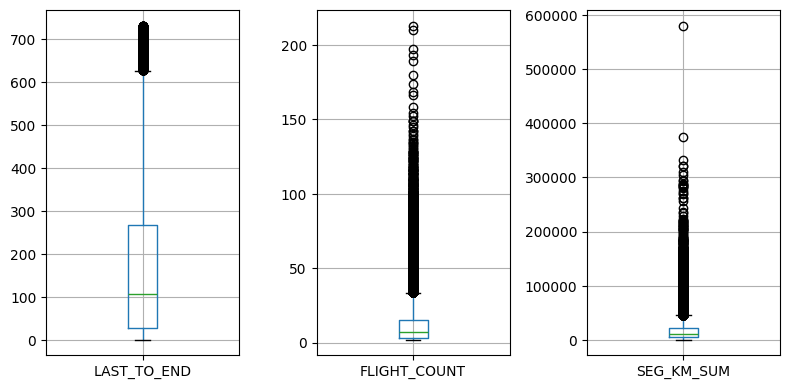

In [23]:
# Outlier Checking

list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df.boxplot(column_name, ax=ax.flatten()[i])
    

plt.tight_layout()
plt.show()

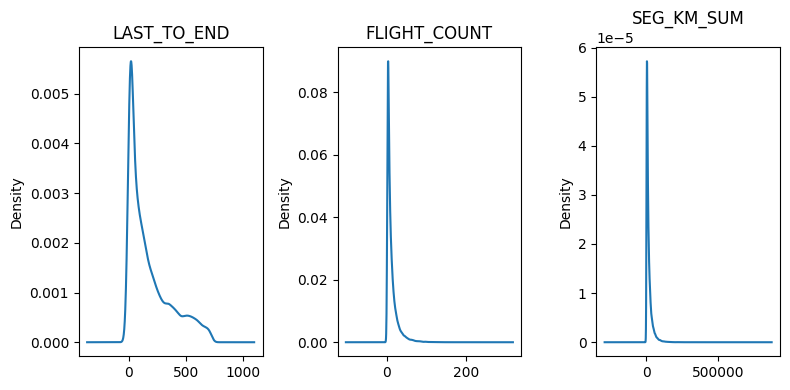

In [24]:
# Distribution of Data
 
list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

In [25]:
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

In [26]:
df

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# Data Pre-processing 

In [27]:
df.corr()

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
LAST_TO_END (R),1.000000,-0.404999,-0.369509
FLIGHT_COUNT (F),-0.404999,1.000000,0.850411
SEG_KM_SUM (M),-0.369509,0.850411,1.000000


In [28]:
from sklearn.preprocessing import QuantileTransformer

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = quantile_trans.fit_transform(df)

In [29]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.355761,3.560518,4.298174
2,-1.161976,3.374222,3.710997
3,-0.072829,1.104747,3.660669
4,-1.513589,5.199338,5.199338
...,...,...,...
62983,0.748009,-5.199338,-2.521925
62984,-0.119468,-0.496390,-0.196015
62985,-0.684763,-5.199338,-1.385354
62986,1.028395,-5.199338,-0.890172


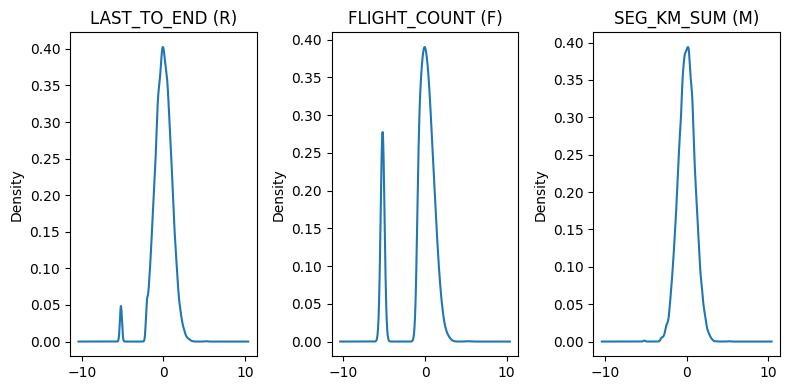

In [30]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df_scaled[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

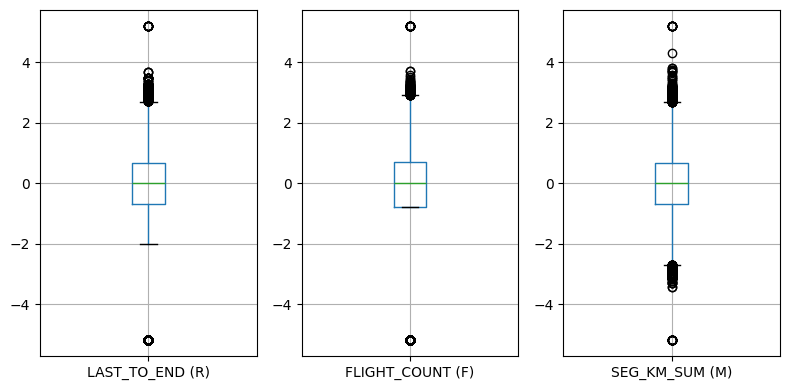

In [31]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 4))

for i, column_name in enumerate(list_columns):
    df_scaled.boxplot(column_name, ax=ax.flatten()[i])

plt.tight_layout()
plt.show()

In [32]:
# Outlier Persentation

for i, j in df_scaled.items():
    q1 = j.quantile(0.25)
    q3 = j.quantile(0.75)
    inter_q = q3 - q1

    j_col = j[(j <= q1 - 1.5 * inter_q) | (j >= q3 + 1.5 * inter_q)]
    percent = np.shape(j_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f" %(i, percent))

Column LAST_TO_END (R) outliers = 1.88
Column FLIGHT_COUNT (F) outliers = 16.69
Column SEG_KM_SUM (M) outliers = 0.73


# Robust Trimmed K Means


In [50]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

df_scaled_np = df_scaled.to_numpy()

RTKM_data = RTKM(df_scaled_np.T)
RTKM_data.perform_clustering(k=2, percent_outliers = 0.10, max_iter = 100, num_members = 2)

#pred clusters return cluster id for data index, pred outliers return outlier index
pred_clusters, pred_outliers = RTKM_data.return_clusters()



# tp, fp, tn, fn, f1_scores, me = accuracy_measures(true_clusters = true_labels.T, pred_clusters = RTKM_yeast.weights, pred_outliers = RTKM_yeast.outliers, membership_option = 'multi')

# print('\n\n Number of true positives: ', tp, '\n\n Number of false positives : ', fp, 
#       '\n\n Number of true negatives: ', tn, '\n\n Number of false negatives: ', fn, 
#       '\n\n F1 scores for each cluster: ', f1_scores, '\n\n Average F1 score: ', np.average(f1_scores),
#      '\n\n me score:', me)

Iteration 100
PALM reached maximum number of iterations
[2 2 0 ... 0 0 0]


<Figure size 800x800 with 0 Axes>

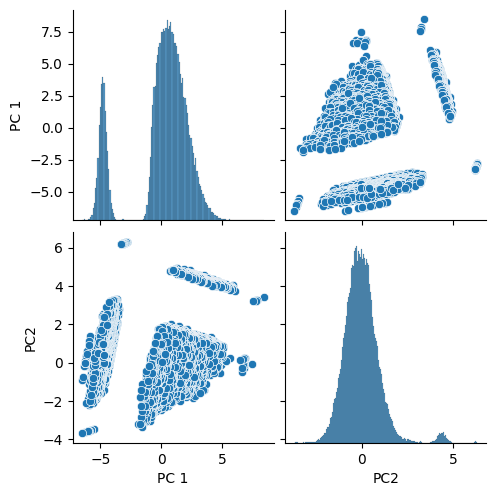

In [34]:
#Visualisasi menggunakan PCA 2D
pca = PCA(n_components=2)
Xnew = pca.fit_transform(df_scaled)
Xnew = pd.DataFrame(Xnew, columns=['PC 1', 'PC2'])

plt.figure(figsize=(8,8))
sns.pairplot(data=Xnew, markers=["o", "D"])

# plt.figure()

# plt.scatter(Xnew[0,:], Xnew[1,:])
# plt.scatter(Xnew[0,pred_outliers], Xnew[1,pred_outliers], c = 'r', label = 'Identified outliers')
# plt.legend()
# plt.title('Robust Trimmed k Means')

# Trimmed K-MEANS

In [16]:
import numpy as np
import pandas as pd

def initialize_centers(data, n_clusters):
    # Randomly initialize cluster centers
    indices = np.random.choice(len(data), n_clusters, replace=False)
    centers = data.iloc[indices].values
    return centers

def assign_clusters(data, centers):
    # Assign each data point to the nearest cluster center
    distances = np.linalg.norm(data.values - centers[:, np.newaxis], axis=2)
    labels = np.argmin(distances, axis=0)
    return labels

def update_centers(data, labels, n_clusters):
    # Update cluster centers based on the mean of assigned data points
    centers = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
    return centers

def trimmed_kmeans(data, n_clusters, out_percentage, max_iter=300):
    # Randomly initialize cluster centers
    centers = initialize_centers(data, n_clusters)
    percentage = 100 - out_percentage
    
    for _ in range(max_iter):
        # Assign each data point to the nearest cluster center
        labels = assign_clusters(data, centers)
        
        # Calculate distances to cluster centers
        distances = np.linalg.norm(data.values - centers[labels], axis=1)
        
        # Calculate the threshold for trimming
        threshold = np.percentile(distances, percentage)
        
        # Identify outliers based on the threshold
        outliers = data[distances > threshold]
        
        # Update cluster centers using non-outliers
        centers = update_centers(data[distances <= threshold], labels[distances <= threshold], n_clusters)
    
    # Create a DataFrame for outliers
    outlier_df = pd.DataFrame(outliers, columns=data.columns)
    
    # Add 'cluster_id' column to the original data
    data['cluster_id'] = labels
    
    # Create a DataFrame for clustered data
    clustered_df = data[data['cluster_id'].isin(np.unique(labels))]
    
    return clustered_df, outlier_df

'''
# Example usage:
data = pd.DataFrame({
    'Type1': [0.0, 0.0, 473.6, 0.0, 0.0, 100.0, 200.0, 300.0],
    'Type2': [0.0, 63.72, 174.0, 996.0, 524.91, 50.0, 150.0, 250.0],
    'Type3': [0.0, 0.0, 31.6, 160.92, 0.0, 10.0, 20.0, 30.0]
})
'''

n_clusters = 2
trim_percentage = 20

clustered_df, outlier_df = trimmed_kmeans(df_scaled, n_clusters, trim_percentage)

print("Clustered Data:")
print(clustered_df)
print("\nOutliers:")
print(outlier_df)

Clustered Data:
       LAST_TO_END (R)  FLIGHT_COUNT (F)  SEG_KM_SUM (M)  cluster_id
0            -5.199338          5.199338        5.199338           0
1            -1.355761          3.191460        5.199338           0
2            -1.144896          3.171475        5.199338           0
3            -0.056486          1.100140        5.199338           0
4            -1.521525          3.245392        5.199338           0
...                ...               ...             ...         ...
62983         0.771450         -5.199338       -2.477116           1
62984        -0.103057         -0.503497       -0.178205           1
62985        -0.664287         -5.199338       -1.375820           1
62986         1.066304         -5.199338       -0.884593           1
62987         1.077782         -5.199338       -0.785965           1

[62988 rows x 4 columns]

Outliers:
       LAST_TO_END (R)  FLIGHT_COUNT (F)  SEG_KM_SUM (M)
0            -5.199338          5.199338        5.199338
1    

In [17]:
#reduce data two dimention
from sklearn.decomposition import PCA

#clustered
pca = PCA(n_components=2)
df_pca = pca.fit_transform(clustered_df)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
df_pca['cluster_id'] = clustered_df.loc[:, clustered_df.columns.isin(['cluster_id'])]

#outliers
df_pca_out = pca.fit_transform(outlier_df)
df_pca_out= pd.DataFrame(df_pca_out, columns=['PC 1', 'PC2'])
df_pca_out['cluster_id'] = "out"


#merge
df_pca_merge = pd.concat([df_pca, df_pca_out])
df_pca_out

,PC 1,PC2,cluster_id
0,12.150181,-1.358185,out
1,8.555366,-3.729514,out
2,8.428801,-3.898926,out
3,6.233374,-3.915190,out
4,8.684809,-3.613003,out
...,...,...,...
12593,-1.376476,-0.313889,out
12594,-1.677419,0.514295,out
12595,-0.557955,1.385367,out
12596,-1.305675,-0.228966,out


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

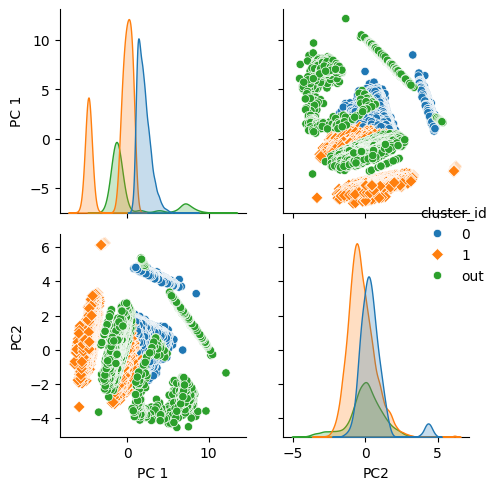

In [18]:
#plot data
import seaborn as sns 

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca_merge, hue='cluster_id', markers=["o", "D"])